## VAE-CTGAN ÏÉùÏÑ± Îç∞Ïù¥ÌÑ∞ Evaluation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import LabelEncoder, MinMaxScaler,OneHotEncoder
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.metrics import roc_curve, auc, log_loss
from sklearn.metrics import classification_report, precision_recall_curve, auc
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from tqdm import tqdm

import torch 
import os
import torch

import warnings
warnings.filterwarnings("ignore")

In [2]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

print(device)

cuda


In [3]:
## Load original data
data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/VAE-CTGAN/dataset/train_category.csv"
data = pd.read_csv(data_path, low_memory=False)

##load test data
test_data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/VAE-CTGAN/dataset/test_category.csv"
test_data = pd.read_csv(test_data_path)

## Load original data
fake_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/VAE-CTAB-GAN/Fake_Datasets/generated_samples_smotified_rounded.csv"
fake = pd.read_csv(fake_path, low_memory=False)

In [4]:
fake['loan_amnt'].value_counts()

loan_amnt
1000.0     6105
9975.0     5102
10000.0    4791
9950.0     4565
10025.0    3990
           ... 
39875.0      28
39750.0      26
39850.0      26
39600.0      24
39975.0      21
Name: count, Length: 1483, dtype: int64

In [ ]:
"""# Îç∞Ïù¥ÌÑ∞ ÌÉÄÏûÖ Î≥ÄÌôò
fake['funded_amnt'] = pd.to_numeric(fake['funded_amnt'], errors='coerce')
fake['loan_amnt'] = pd.to_numeric(fake['loan_amnt'], errors='coerce')

# 0ÏùÑ loan_amntÎ°ú ÎåÄÏ≤¥
mask = fake['funded_amnt'] == 0
fake.loc[mask, 'funded_amnt'] = fake.loc[mask, 'loan_amnt']

mask2 = fake['loan_amnt'] == 0
fake.loc[mask2, 'loan_amnt'] = fake.loc[mask2, 'funded_amnt']

# Ïó¨Ï†ÑÌûà 0Ïù∏ Í≤ΩÏö∞ ÌôïÏù∏
remaining = (fake['funded_amnt'] == 0).sum()
print(f"‚úÖ ÏµúÏ¢Ö funded_amnt == 0 Í∞úÏàò: {remaining}")
"""

‚úÖ ÏµúÏ¢Ö funded_amnt == 0 Í∞úÏàò: 202


In [ ]:
"""# ÌèâÍ∑†Í∞í Í≥ÑÏÇ∞ (0Ïù¥ ÏïÑÎãå Í∞í Í∏∞Ï§Ä)
mean_funded_amnt = fake.loc[fake['funded_amnt'] > 0, 'funded_amnt'].mean()

# 0Ïù∏ Í∞íÏóê ÌèâÍ∑† ÎåÄÏûÖ
fake.loc[fake['funded_amnt'] == 0, 'funded_amnt'] = mean_funded_amnt

mask2 = fake['loan_amnt'] == 0
fake.loc[mask2, 'loan_amnt'] = fake.loc[mask2, 'funded_amnt']

print("‚úÖ funded_amnt == 0 Í∞úÏàò (after fill):", (fake['loan_amnt'] == 0).sum())
"""

‚úÖ funded_amnt == 0 Í∞úÏàò (after fill): 0


In [5]:
fake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540000 entries, 0 to 539999
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   last_fico_range_high  540000 non-null  int64  
 1   annual_inc            540000 non-null  float64
 2   dti                   540000 non-null  float64
 3   mo_sin_old_rev_tl_op  540000 non-null  float64
 4   revol_util            540000 non-null  float64
 5   int_rate              540000 non-null  float64
 6   installment           540000 non-null  float64
 7   avg_cur_bal           540000 non-null  float64
 8   revol_bal             540000 non-null  float64
 9   debt_settlement_flag  540000 non-null  object 
 10  sub_grade             540000 non-null  object 
 11  home_ownership        540000 non-null  object 
 12  purpose               540000 non-null  object 
 13  grade                 540000 non-null  object 
 14  total_pymnt           540000 non-null  float64
 15  

In [6]:
fake['loan_status'].value_counts()

loan_status
1    540000
Name: count, dtype: int64

In [92]:
"""fake['loan_status'] = 1
fake.columns"""

"fake['loan_status'] = 1\nfake.columns"

In [7]:
for col in data.columns:
    print(f"{col} feature\n{data[col].unique()}")

last_fico_range_high feature
[744. 739. 614. 604. 654. 804. 824. 659. 559. 724. 769. 589. 499. 694.
 584. 719. 689. 669. 779. 684. 674. 749. 649. 664. 734. 639. 634. 594.
 619. 544. 699. 679. 759. 729. 784. 709. 549. 629. 704. 564. 579. 529.
 569. 714. 754. 599. 764. 539. 574. 534. 519. 524. 644. 814. 609. 794.
 789. 829. 774. 799. 514. 819. 834. 509. 624. 839. 554. 809. 504. 844.
 850.   0.]
annual_inc feature
[50000.  60000.  75000.  ... 31235.  75388.  13235.5]
dti feature
[  4.66  16.14  24.67 ...  97.94  56.6  131.58]
mo_sin_old_rev_tl_op feature
[126.         151.         292.         206.         424.
 114.         308.         131.         275.         315.
 150.         365.         105.         333.         161.
 157.          95.         321.          81.         135.
 130.         117.         102.         223.         503.
 178.          56.         103.         199.         137.
 123.         138.          29.         189.         187.
  30.         118.         186.     

In [8]:
for col in fake.columns:
    print(f"{col} feature\n{fake[col].unique()}")

last_fico_range_high feature
[579 634 574 559 564 539 609 534 514 549 524 684 589 629 504 499 744 724
 649 519 509 584 544 749 624 569 554 619 614 529 594 659 644 599 669 654
 639 729 674 604 679 704 689 694 714 709 699 664 719 734 739 774 764 759
 754 784 804 794 799 844 769 789 809 779 814 834 839 850 829 819 824]
annual_inc feature
[ 41474.    92088.    56633.88 ... 308000.   418000.    11246.  ]
dti feature
[19.19 40.41 13.98 ... 54.07 66.08 54.9 ]
mo_sin_old_rev_tl_op feature
[131.79654546 147.25660615 235.32812066 ... 463.42177096 197.70136527
  72.22332692]
revol_util feature
[0.814 0.841 0.668 ... 1.179 1.115 1.121]
int_rate feature
[0.16003498 0.2249981  0.16643687 ... 0.05697789 0.19018915 0.12784924]
installment feature
[520.28 588.08 182.61 ... 549.69 780.85 810.26]
avg_cur_bal feature
[11329.84176457 19868.99183501   616.45755647 ...  3659.43953035
  1194.60549416  1297.61762528]
revol_bal feature
[18883.39802871  1958.59703028 52567.55397204 ...  8665.64624839
 35320.3949

In [9]:
fake['term_months'].value_counts()

term_months
36    315414
60    224586
Name: count, dtype: int64

In [96]:
## term_months Ïò§Î•ò ÏàòÏ†ï
fake['term_months'] = fake['term_months'].apply(lambda x : 36 if abs(x-36)<=abs(x-60) else 60)

In [97]:
fake['term_months'].value_counts()

term_months
36    319570
60    220430
Name: count, dtype: int64

In [10]:
data.columns

Index(['last_fico_range_high', 'annual_inc', 'dti', 'mo_sin_old_rev_tl_op',
       'revol_util', 'int_rate', 'installment', 'avg_cur_bal', 'revol_bal',
       'debt_settlement_flag', 'sub_grade', 'home_ownership', 'purpose',
       'grade', 'total_pymnt', 'total_pymnt_inv', 'funded_amnt', 'loan_amnt',
       'credit_history_years', 'term_months', 'loan_status'],
      dtype='object')

In [11]:
#keep_features = ['grade', 'term_months', 'total_pymnt', 'total_pymnt_inv','total_il_high_credit_limit', 'loan_amnt']
keep_features = ['grade', 'total_pymnt', 'total_pymnt_inv', 'loan_amnt','funded_amnt']
data_classification = data.copy()
test_classification = test_data.copy()
fake_classification = fake.copy()

data_classification = data_classification.drop(columns = keep_features)
test_classification = test_classification.drop(columns = keep_features)
fake_classification = fake_classification.drop(columns = keep_features)

In [12]:
data_classification.columns

Index(['last_fico_range_high', 'annual_inc', 'dti', 'mo_sin_old_rev_tl_op',
       'revol_util', 'int_rate', 'installment', 'avg_cur_bal', 'revol_bal',
       'debt_settlement_flag', 'sub_grade', 'home_ownership', 'purpose',
       'credit_history_years', 'term_months', 'loan_status'],
      dtype='object')

In [13]:
fake_classification.columns

Index(['last_fico_range_high', 'annual_inc', 'dti', 'mo_sin_old_rev_tl_op',
       'revol_util', 'int_rate', 'installment', 'avg_cur_bal', 'revol_bal',
       'debt_settlement_flag', 'sub_grade', 'home_ownership', 'purpose',
       'credit_history_years', 'term_months', 'loan_status'],
      dtype='object')

In [14]:
## data Encoding
Labelencoding_features = ['term_months', 'sub_grade']
onehot_features = ['debt_settlement_flag', 'home_ownership', 'purpose']

onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

label_encoders = {}
for col in Labelencoding_features:
    le = LabelEncoder()
    data_classification[col] = le.fit_transform(data_classification[col])
    label_encoders[col] = le

# One-Hot Encoding
onehot_encoded = onehot_encoder.fit_transform(data_classification[onehot_features])
onehot_encoded_df = pd.DataFrame(
    onehot_encoded, 
    columns=onehot_encoder.get_feature_names_out(onehot_features),
    index=data_classification.index
)

# Merge
data_classification.drop(columns=onehot_features, inplace=True)
data_classification = pd.concat([data_classification, onehot_encoded_df], axis=1)

print("‚úÖ Encoding ÏôÑÎ£å! Í≤∞Í≥º shape:", data_classification.shape)

‚úÖ Encoding ÏôÑÎ£å! Í≤∞Í≥º shape: (1116458, 35)


In [15]:
##Fake data encoding
for col in Labelencoding_features:
    le = label_encoders[col]
    fake_classification[col] = le.transform(fake_classification[col])

# One-Hot Encoding (trainÏóêÏÑú fitÎêú onehot_encoder Ïû¨ÏÇ¨Ïö©)
onehot_encoded_test = onehot_encoder.transform(fake_classification[onehot_features])
onehot_encoded_test_df = pd.DataFrame(
    onehot_encoded_test,
    columns=onehot_encoder.get_feature_names_out(onehot_features),
    index=fake_classification.index
)

# Merge
fake_classification.drop(columns=onehot_features, inplace=True)
fake_classification = pd.concat([fake_classification, onehot_encoded_test_df], axis=1)

print("‚úÖ ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ Ïù∏ÏΩîÎî© ÏôÑÎ£å! Í≤∞Í≥º shape:", fake_classification.shape)

##Test data encoding
for col in Labelencoding_features:
    le = label_encoders[col]
    test_classification[col] = le.transform(test_classification[col])

# One-Hot Encoding (trainÏóêÏÑú fitÎêú onehot_encoder Ïû¨ÏÇ¨Ïö©)
onehot_encoded_test = onehot_encoder.transform(test_classification[onehot_features])
onehot_encoded_test_df = pd.DataFrame(
    onehot_encoded_test,
    columns=onehot_encoder.get_feature_names_out(onehot_features),
    index=test_classification.index
)

# Merge
test_classification.drop(columns=onehot_features, inplace=True)
test_classification = pd.concat([test_classification, onehot_encoded_test_df], axis=1)

print("‚úÖ ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ Ïù∏ÏΩîÎî© ÏôÑÎ£å! Í≤∞Í≥º shape:", test_classification.shape)

‚úÖ ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ Ïù∏ÏΩîÎî© ÏôÑÎ£å! Í≤∞Í≥º shape: (540000, 35)
‚úÖ ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ Ïù∏ÏΩîÎî© ÏôÑÎ£å! Í≤∞Í≥º shape: (744306, 35)


In [16]:
data_x = data_classification.drop(columns='loan_status')
data_y = data_classification[['loan_status']]

X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, train_size=0.8, test_size=0.2, random_state=42, stratify=data_y)

train_classification = pd.concat([X_train, y_train], axis=1)

In [17]:
from sklearn.utils import shuffle

train_data = pd.concat([train_classification, fake_classification])
train_data['loan_status'].value_counts()
train_data = shuffle(train_data, random_state=42)

In [18]:
train_data['loan_status'].value_counts()

loan_status
0    718935
1    714231
Name: count, dtype: int64

In [19]:
X_train = train_data.drop(columns='loan_status')
y_train = train_data[['loan_status']]

X_test = test_classification.drop(columns='loan_status')
y_test = test_classification[['loan_status']]

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier

model = XGBClassifier( 
    n_estimators=500,
    learning_rate=0.01,
    objective='binary:logistic',
    eval_metric="logloss",
    random_state=42,
    verbose = True
)

[0]	validation_0-logloss:0.68656	validation_1-logloss:0.68461
[1]	validation_0-logloss:0.68010	validation_1-logloss:0.67819
[2]	validation_0-logloss:0.67377	validation_1-logloss:0.67190
[3]	validation_0-logloss:0.66757	validation_1-logloss:0.66574
[4]	validation_0-logloss:0.66149	validation_1-logloss:0.65969
[5]	validation_0-logloss:0.65552	validation_1-logloss:0.65377
[6]	validation_0-logloss:0.64966	validation_1-logloss:0.64795
[7]	validation_0-logloss:0.64392	validation_1-logloss:0.64225
[8]	validation_0-logloss:0.63828	validation_1-logloss:0.63666
[9]	validation_0-logloss:0.63275	validation_1-logloss:0.63117
[10]	validation_0-logloss:0.62732	validation_1-logloss:0.62579
[11]	validation_0-logloss:0.62199	validation_1-logloss:0.62050
[12]	validation_0-logloss:0.61676	validation_1-logloss:0.61532
[13]	validation_0-logloss:0.61163	validation_1-logloss:0.61023
[14]	validation_0-logloss:0.60658	validation_1-logloss:0.60523
[15]	validation_0-logloss:0.60163	validation_1-logloss:0.60033
[1

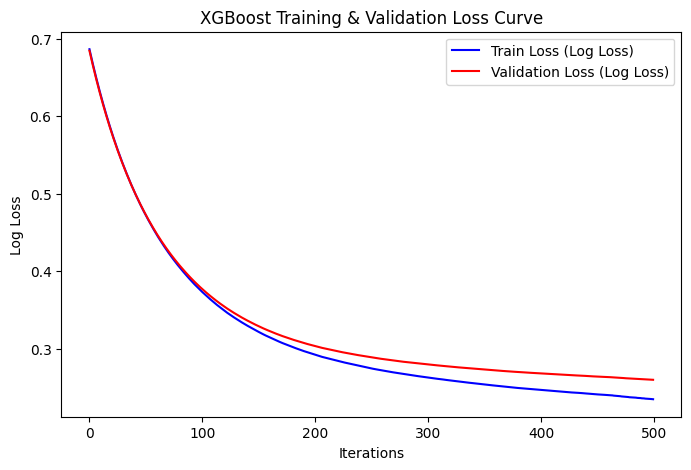

üîπ Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.89      0.93    599114
           1       0.66      0.89      0.76    145192

    accuracy                           0.89    744306
   macro avg       0.81      0.89      0.84    744306
weighted avg       0.91      0.89      0.89    744306



In [21]:
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss Ï†ÄÏû•
    verbose=True
)

# 3Ô∏è‚É£ ÌïôÏäµ Í≥ºÏ†ïÏóêÏÑú Ï†ÄÏû•Îêú Train & Validation Loss Í∞ÄÏ†∏Ïò§Í∏∞
evals_result = model.evals_result()  # üîπ Î≥ÄÍ≤ΩÎêú ÏΩîÎìú (ÌïôÏäµ ÌõÑ Í≤∞Í≥º ÌôïÏù∏)
train_loss = evals_result['validation_0']['logloss']  # Training Loss
val_loss = evals_result['validation_1']['logloss']    # Validation Loss

# 4Ô∏è‚É£ Train & Validation Loss ÏãúÍ∞ÅÌôî
plt.figure(figsize=(8, 5))
plt.plot(train_loss, label='Train Loss (Log Loss)', color='blue')
plt.plot(val_loss, label='Validation Loss (Log Loss)', color='red')
plt.xlabel('Iterations')
plt.ylabel('Log Loss')
plt.title('XGBoost Training & Validation Loss Curve')
plt.legend()
plt.show()

# 5Ô∏è‚É£ ÏòàÏ∏° Î∞è ÌèâÍ∞Ä
#y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRCÏóê ÌïÑÏöî

threshold = 0.5
y_pred = (y_prob >= threshold).astype(int)

# üîπ Classification Report Ï∂úÎ†•
print("üîπ Classification Report:")
print(classification_report(y_test, y_pred))

# 6Ô∏è‚É£ ROC Curve & AUC-ROC Í≥ÑÏÇ∞
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc_roc = auc(fpr, tpr)

# 7Ô∏è‚É£ Precision-Recall Curve & AU-PRC Í≥ÑÏÇ∞
precision, recall, _ = precision_recall_curve(y_test, y_prob)
auc_prc = auc(recall, precision)

In [22]:
from sklearn.metrics import confusion_matrix
# confusion matrix Í≥ÑÏÇ∞
cm = confusion_matrix(y_test, y_pred)

# Ìñâ: Ïã§Ï†úÍ∞í (y_test), Ïó¥: ÏòàÏ∏°Í∞í (y_pred)
# [[TP, FP],
#  [FN, TN]]
TN, FP, FN, TP= cm.ravel()

print("‚úÖ Confusion Matrix")
print(cm)
print(f"\nTrue Positives (TP): {TP}")
print(f"False Positives (FP): {FP}")
print(f"True Negatives (TN): {TN}")
print(f"False Negatives (FN): {FN}")

‚úÖ Confusion Matrix
[[531434  67680]
 [ 15358 129834]]

True Positives (TP): 129834
False Positives (FP): 67680
True Negatives (TN): 531434
False Negatives (FN): 15358


## VAE-CTGAN ÏÉùÏÑ± Îç∞Ïù¥ÌÑ∞ Portfolio

In [23]:
def encode_features(df, label_encoders, onehot_encoder, label_cols, onehot_cols):
    df = df.copy()
    
    # Label Encoding
    for col in label_cols:
        le = label_encoders[col]
        df[col] = le.transform(df[col])

    # One-Hot Encoding
    onehot_encoded = onehot_encoder.transform(df[onehot_cols])
    onehot_df = pd.DataFrame(
        onehot_encoded, 
        columns=onehot_encoder.get_feature_names_out(onehot_cols),
        index=df.index
    )

    df.drop(columns=onehot_cols, inplace=True)
    df = pd.concat([df, onehot_df], axis=1)
    
    return df

In [24]:
summary_with_sharpe = []

def linear_portfolio(top_10_indices):
    selected = test_data.loc[top_10_indices.index].copy()
    returns = (selected['total_pymnt_inv'] - selected['loan_amnt']) / selected['loan_amnt']
    
    avg_return = returns.mean()
    std_return = returns.std()
    sharpe_ratio = avg_return / std_return if std_return != 0 else np.nan

    summary_with_sharpe.append({
        'Average Return': avg_return * 100,
        'Std Dev': std_return,
        'Sharpe Ratio': sharpe_ratio
    }) 

In [31]:
data.columns

Index(['last_fico_range_high', 'annual_inc', 'dti', 'mo_sin_old_rev_tl_op',
       'revol_util', 'int_rate', 'installment', 'avg_cur_bal', 'revol_bal',
       'debt_settlement_flag', 'sub_grade', 'home_ownership', 'purpose',
       'grade', 'total_pymnt', 'total_pymnt_inv', 'funded_amnt', 'loan_amnt',
       'credit_history_years', 'term_months', 'loan_status'],
      dtype='object')

In [25]:
drop2 = ['loan_status', 'return']

scaler = StandardScaler()
reg = LinearRegression()

fully_paid_indices = (y_pred == 0)
test_regression = test_data[fully_paid_indices]
test_regression['return'] = (test_regression['total_pymnt_inv'] - test_regression['funded_amnt'])/(test_regression['funded_amnt']+1e-8)

train_regression = data.copy()
train_regression['return'] = (train_regression['total_pymnt_inv'] - train_regression['funded_amnt'])/train_regression['funded_amnt']

drop_features = ['loan_status', 'total_pymnt_inv', 'total_pymnt','funded_amnt','grade','loan_amnt']
train_regression = train_regression.drop(columns=drop_features)
test_regression = test_regression.drop(columns=drop_features)

fake_regression = fake.copy()
fake_regression['return'] = (fake_regression['total_pymnt_inv'] - fake_regression['funded_amnt'])/fake_regression['funded_amnt']
fake_regression = fake_regression.drop(columns=drop_features)

train_total = pd.concat([train_regression, fake_regression])

########## Encoding categorical data ######################
train_total = encode_features(train_total, label_encoders, onehot_encoder, Labelencoding_features, onehot_features)
test_regression = encode_features(test_regression, label_encoders, onehot_encoder, Labelencoding_features, onehot_features)

data_x = train_total.drop(columns='return')
data_y = train_total[['return']]

test_x = test_regression.drop(columns = 'return')
test_y = test_regression[['return']]

data_x_scaled = scaler.fit_transform(data_x)

X_train = data_x_scaled
y_train = data_y

test_x_scaled = scaler.transform(test_x)

reg.fit(X_train, y_train)

#print(reg.coef_)
y_pred = reg.predict(test_x_scaled)

print("RMSE:", mean_squared_error(test_y, y_pred, squared=False))
print("R¬≤:", r2_score(test_y, y_pred))

test_regression['predicted_return'] = reg.predict(test_x_scaled)
top_10_percent = test_regression.sort_values(by='predicted_return', ascending=False).head(int(len(test_regression)*0.1))

linear_portfolio(top_10_percent)

RMSE: 0.18993273842625127
R¬≤: -0.343668827018466


In [26]:
returns_with_sharpe_df = pd.DataFrame(summary_with_sharpe)

returns_with_sharpe_df.head()

Average Return   Std Dev  Sharpe Ratio
0        15.13518  0.121302      1.247729

## Analysis between Original and VAE-TableGAN Samples

In [27]:
label1_data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/VAE-CTGAN/dataset/train_category_1.csv"
label1_data = pd.read_csv(label1_data_path, low_memory=False)

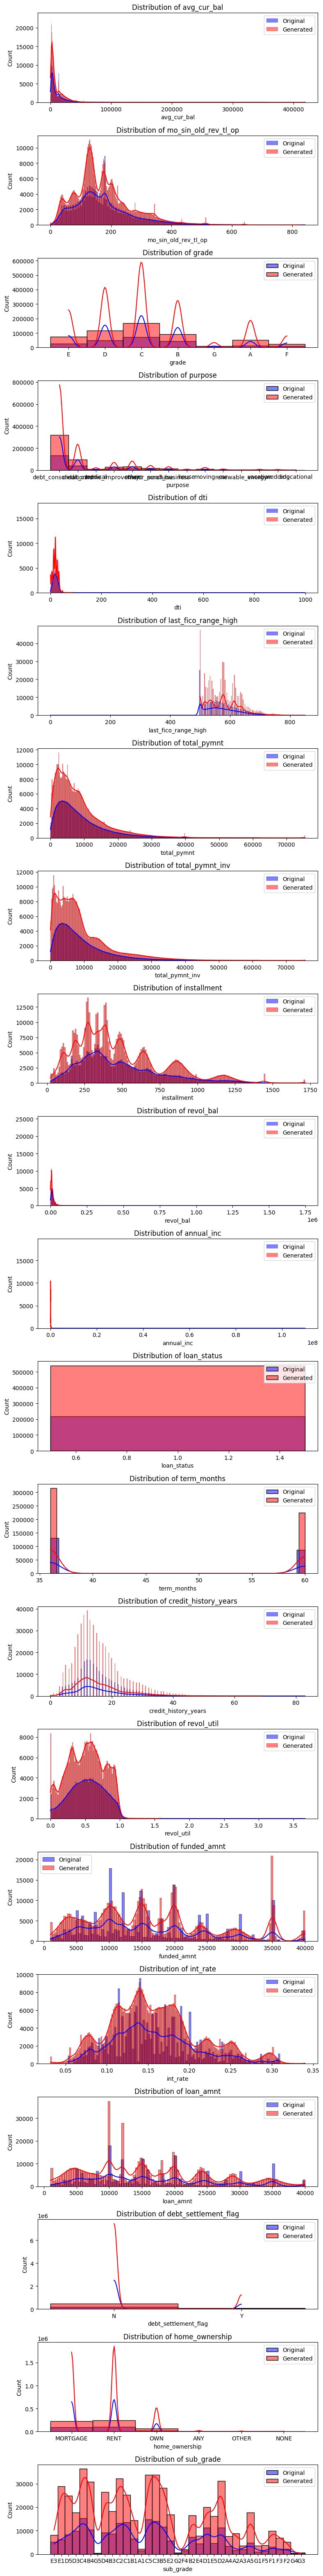

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# ÏõêÎ≥∏ Îç∞Ïù¥ÌÑ∞ÏôÄ TableGAN ÏÉùÏÑ± Îç∞Ïù¥ÌÑ∞ Î∂àÎü¨Ïò§Í∏∞
# ÏõêÎ≥∏ Îç∞Ïù¥ÌÑ∞: original_df
# TableGANÏù¥ ÏÉùÏÑ±Ìïú Îç∞Ïù¥ÌÑ∞: generated_df

# Í≥µÌÜµ feature ÏÑ†ÌÉù (ÌòπÏãú Ïª¨ÎüºÏù¥ Îã§Î•º ÏàòÎèÑ ÏûàÏúºÎãà)
common_features = list(set(data.columns) & set(fake.columns))
original_df = label1_data[common_features]
generated_df = fake[common_features]

# ------------------------------
# 1Ô∏è‚É£ ÌûàÏä§ÌÜ†Í∑∏Îû® ÎπÑÍµê (Í∞Å feature Î∂ÑÌè¨)
# ------------------------------
num_features = len(common_features)
fig, axes = plt.subplots(nrows=num_features, ncols=1, figsize=(8, num_features * 3))

for i, feature in enumerate(common_features):
    sns.histplot(original_df[feature], color='blue', label='Original', kde=True, ax=axes[i], alpha=0.5)
    sns.histplot(generated_df[feature], color='red', label='Generated', kde=True, ax=axes[i], alpha=0.5)
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].legend()

plt.tight_layout()
plt.show()

In [118]:
label1_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217789 entries, 0 to 217788
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   last_fico_range_high  217789 non-null  float64
 1   annual_inc            217789 non-null  float64
 2   dti                   217789 non-null  float64
 3   mo_sin_old_rev_tl_op  217789 non-null  float64
 4   revol_util            217789 non-null  float64
 5   int_rate              217789 non-null  float64
 6   installment           217789 non-null  float64
 7   avg_cur_bal           217789 non-null  float64
 8   revol_bal             217789 non-null  float64
 9   debt_settlement_flag  217789 non-null  object 
 10  sub_grade             217789 non-null  object 
 11  home_ownership        217789 non-null  object 
 12  purpose               217789 non-null  object 
 13  grade                 217789 non-null  object 
 14  total_pymnt           217789 non-null  float64
 15  

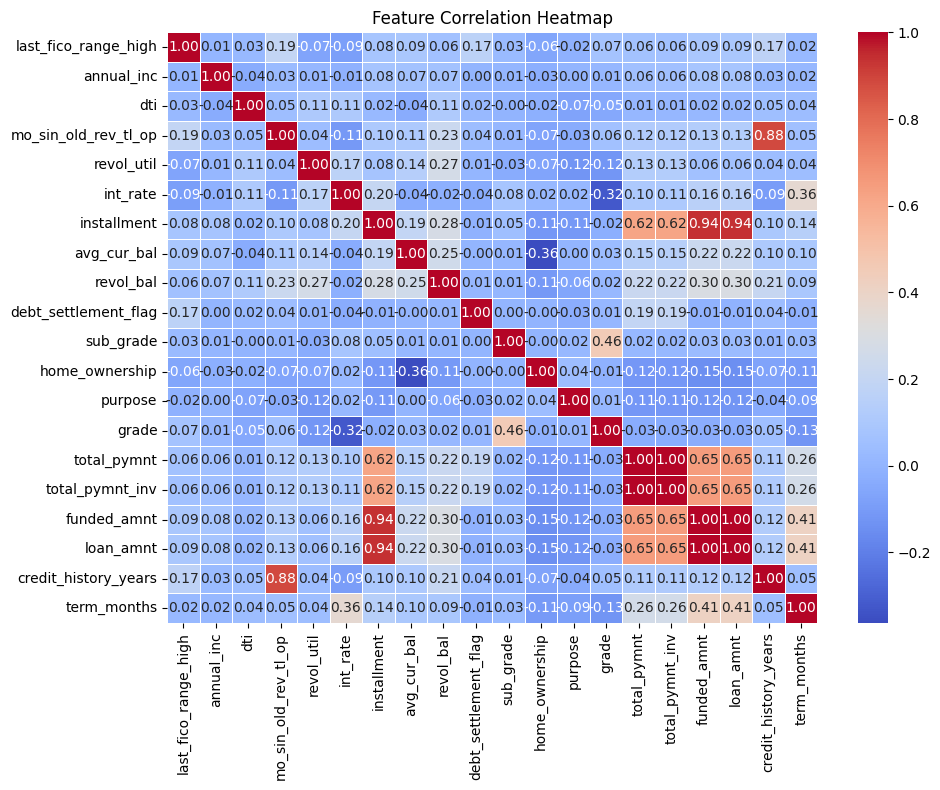

In [119]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = label1_data.copy()

if 'loan_status' in df.columns:
    df = df.drop(columns=['loan_status'])

# Î¨∏ÏûêÏó¥ ‚Üí Ïà´Ïûê Î≥ÄÌôò (ÌïÑÏöîÏãú)
for col in df.select_dtypes(include='object').columns:
    df[col] = pd.factorize(df[col])[0]

corr_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.tight_layout()

plt.savefig("correlation_heatmap.png", dpi=300)

plt.show()


In [120]:
for col in data.columns:
    if pd.api.types.is_numeric_dtype(data[col]):
        zero_count = (data[col] == 0).sum()
        if zero_count > 0:
            print(f"üî¥ Column '{col}' has {zero_count} zero values.")
        else:
            print(f"‚úÖ Column '{col}' has no zero values.")
    else:
        print(f"‚ÑπÔ∏è Column '{col}' is not numeric, skipped.")


üî¥ Column 'last_fico_range_high' has 125 zero values.
üî¥ Column 'annual_inc' has 653 zero values.
üî¥ Column 'dti' has 828 zero values.
‚úÖ Column 'mo_sin_old_rev_tl_op' has no zero values.
üî¥ Column 'revol_util' has 6553 zero values.
‚úÖ Column 'int_rate' has no zero values.
‚úÖ Column 'installment' has no zero values.
üî¥ Column 'avg_cur_bal' has 424 zero values.
üî¥ Column 'revol_bal' has 6200 zero values.
‚ÑπÔ∏è Column 'debt_settlement_flag' is not numeric, skipped.
‚ÑπÔ∏è Column 'sub_grade' is not numeric, skipped.
‚ÑπÔ∏è Column 'home_ownership' is not numeric, skipped.
‚ÑπÔ∏è Column 'purpose' is not numeric, skipped.
‚ÑπÔ∏è Column 'grade' is not numeric, skipped.
üî¥ Column 'total_pymnt' has 837 zero values.
üî¥ Column 'total_pymnt_inv' has 932 zero values.
‚úÖ Column 'funded_amnt' has no zero values.
‚úÖ Column 'loan_amnt' has no zero values.
‚úÖ Column 'credit_history_years' has no zero values.
‚úÖ Column 'term_months' has no zero values.
üî¥ Column 'loan_status' ha

In [121]:
for col in data.columns:
    if pd.api.types.is_numeric_dtype(data[col]):
        negative_count = (data[col] < 0).sum()
        if negative_count > 0:
            print(f"üî¥ Column '{col}' has {negative_count} negative values.")
        else:
            print(f"‚úÖ Column '{col}' has no negative values.")
    else:
        print(f"‚ÑπÔ∏è Column '{col}' is not numeric, skipped.")


‚úÖ Column 'last_fico_range_high' has no negative values.
‚úÖ Column 'annual_inc' has no negative values.
‚úÖ Column 'dti' has no negative values.
‚úÖ Column 'mo_sin_old_rev_tl_op' has no negative values.
‚úÖ Column 'revol_util' has no negative values.
‚úÖ Column 'int_rate' has no negative values.
‚úÖ Column 'installment' has no negative values.
‚úÖ Column 'avg_cur_bal' has no negative values.
‚úÖ Column 'revol_bal' has no negative values.
‚ÑπÔ∏è Column 'debt_settlement_flag' is not numeric, skipped.
‚ÑπÔ∏è Column 'sub_grade' is not numeric, skipped.
‚ÑπÔ∏è Column 'home_ownership' is not numeric, skipped.
‚ÑπÔ∏è Column 'purpose' is not numeric, skipped.
‚ÑπÔ∏è Column 'grade' is not numeric, skipped.
‚úÖ Column 'total_pymnt' has no negative values.
‚úÖ Column 'total_pymnt_inv' has no negative values.
‚úÖ Column 'funded_amnt' has no negative values.
‚úÖ Column 'loan_amnt' has no negative values.
‚úÖ Column 'credit_history_years' has no negative values.
‚úÖ Column 'term_months' has no neg